In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


# Get data

In [2]:
with open("../../data/ctgov/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [3]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [4]:
df_annotations_num_arms_known = df_annotations[~df_annotations.num_arms.isna()]

In [5]:
df_annotations_num_arms_known = df_annotations_num_arms_known.sample(1000)

In [6]:
def get_num_arms_clean(num):
    if num >= 5:
        num = 5
    return num
df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)

# Train and evaluate the number of arms extractor

In [64]:
sys.path.append("../../front_end")
from util.page_tokeniser import tokenise_pages, tokenise_text, tokenise_text_and_lowercase

In [10]:
import spacy
from spacy.matcher import Matcher
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'lemmatizer'])



In [346]:
word2num = {'one': 1,
 'two': 2,
 'three': 3,
 'four': 4,
 'five': 5,
 'six': 6,
 'seven': 7,
 'eight': 8,
 'nine': 9,
 'ten': 10,
 'eleven': 11,
 'twelve': 12,
 'thirteen': 13,
 'fourteen': 14,
 'fifteen': 15,
 'sixteen': 16,
 'seventeen': 17,
 'eighteen': 18,
 'nineteen': 19,
 'both': 2,
 'single': 2}

In [347]:
number_words = list(word2num)

In [348]:
for n in range(1, 20):
    word2num[str(n)]= n

In [349]:
numbers_above_3 = list([w for w in word2num if word2num[w] >= 3])

In [350]:
matcher = Matcher(nlp.vocab)
patterns = [ #[{"LIKE_NUM":True},  {"LOWER": {"IN": ["treatment", "study", "dose"]}, "OP":"?"}, {"LOWER": {"IN": ["arm", "arms", "group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
           [{"LOWER":{"IN":number_words}},  {"LOWER": {"IN": ["treatment", "study", "dose"]}}, {"LOWER": {"IN": ["arm", "arms", "group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
#            [{"LOWER":{"IN":number_words}},  {"LOWER": {"IN": ["group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
             [{"LOWER":{"IN":list(word2num)}},{"LOWER":"-", "OP":"?"}, {"LOWER": {"IN": [ "armed"]}}]
]
matcher.add("arms", patterns)

In [351]:
doc = spacy.tokens.doc.Doc(
            nlp.vocab, words=["5", "arms"])
matcher(doc)

[]

In [352]:
#tokenised_pages = [["5", "arms"]]
# if True:
def process(self, tokenised_pages: list) -> tuple:
    """
    Identify the trial phase.
    :param tokenised_pages: List of lists of tokens of each page.
    :return: The prediction (str) and a map from phase to the pages it's mentioned in.
    """

    tokenised_pages = [[string.lower() for string in sublist] for sublist in tokenised_pages]

    phase_to_pages = {}

    for page_number, page_tokens in enumerate(tokenised_pages):
        doc = spacy.tokens.doc.Doc(
            nlp.vocab, words=page_tokens)
        matches = matcher(doc)
        for word, start, end in matches:
            phase_number = doc[start:end]
            if phase_number not in phase_to_pages:
                phase_to_pages[phase_number] = []
            phase_to_pages[phase_number].append(page_number)

    phase_to_pages = sorted(phase_to_pages.items(), key=lambda v: len(v[1]), reverse=True)

    prediction = 0
    if len(phase_to_pages) == 1:
        for word in phase_to_pages[0][0]:
            if word.text in word2num:
                prediction = word2num[word.text]
                break
    if prediction > 5:
        prediction = 5
                
    phase_to_pages = [(phrase.text, value) for phrase, value in phase_to_pages]

    return {"prediction": prediction, "pages": dict(phase_to_pages)}

In [353]:
df_val = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "val"]

In [354]:
def get_num_arms(text):
    toks = tokenise_text_and_lowercase(text)
    result = process(None, [toks])
    return result["prediction"]

In [355]:
def get_pages(text):
    toks = tokenise_text_and_lowercase(text)
    result = process(None, [toks])
    return result["pages"]

In [356]:
pred_num_arms = df_val.text.apply(get_num_arms)

In [357]:
df_val["pred_num_arms"] =pred_num_arms

/tmp/ipykernel_10079/3108339990.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms"] =pred_num_arms


In [358]:
df_val["pages"] = df_val.text.apply(get_pages)

/tmp/ipykernel_10079/1874208678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pages"] = df_val.text.apply(get_pages)


In [359]:
pred_num_arms

8716    0
6088    2
2120    2
7613    0
5251    0
       ..
4939    0
8911    2
7166    0
7768    0
2577    0
Name: text, Length: 97, dtype: int64

In [360]:
num_arms_ground_truths = df_val.num_arms_clean

In [361]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.1134020618556701


''

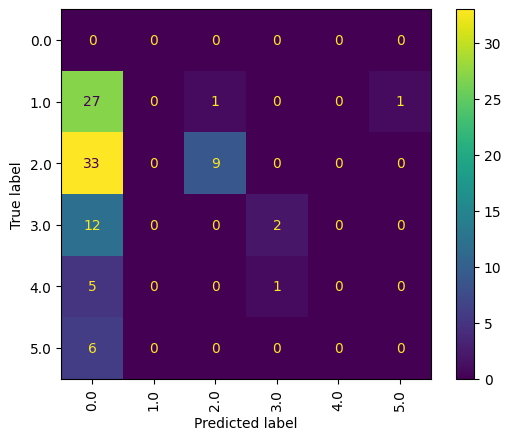

In [362]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms)
plt.xticks(rotation=90)
;

In [363]:
accuracy_score(num_arms_ground_truths[pred_num_arms > 0], pred_num_arms[pred_num_arms > 0])

0.7857142857142857

In [364]:
df_val

,file,nct_id,train_val,num_arms,num_subjects,phase,intervention_type,country,has_sap,text,num_arms_clean,pred_num_arms,pages
8716,73_NCT02831673_Prot_000.pdf,NCT02831673,val,2.0,NaN,Phase 3,Drug,"US,AR,AU,BE,CA,FR,DE,IT,KR,MX,NL,PT,RO,RU,ZA,E...",0,\n2015N242978_01 CONFIDENTIAL\nViiV Healthcare...,2.0,0,{'two treatment arms': [0]}
6088,51_NCT01826851_Prot_SAP_000.pdf,NCT01826851,val,2.0,NaN,Phase 2,Drug,US,1,\nParasternal intercostal nerve block in cardi...,2.0,2,{'both treatment arms': [0]}
2120,17_NCT03876717_Prot_SAP_003.pdf,NCT03876717,val,2.0,NaN,Phase 4,Drug,DK,1,\nSINBAD: Sequestrant in Bile Acid Diarrhoea ...,2.0,2,{'two treatment arms': [0]}
7613,63_NCT03809663_Prot_000.pdf,NCT03809663,val,6.0,NaN,Phase 2,Drug,"US,AU,CA,CZ,EE,DE,HU,JP,KR,LV,PL,ES,CH,UA,GB",0,\nProduct: Tezepelumab \nProtocol Number: 20...,5.0,0,{}
5251,44_NCT01891344_Prot_000.pdf,NCT01891344,val,1.0,NaN,Phase 2,Drug,"US,AU,CA,FR,ES,GB",0,"\nClovis Oncology, Inc. Clinical Protocol \nO...",1.0,0,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,41_NCT02841241_Prot_SAP_ICF_000.pdf,NCT02841241,val,1.0,NaN,Phase 2,Drug,US,1,\nCover Page \n\nOfficial Title: Esmolol to Co...,1.0,0,{}
8911,75_NCT01824875_Prot_SAP_000.pdf,NCT01824875,val,2.0,NaN,Phase 2,Drug,US,1,\nE2211 \n \n\n1 \n\nA Randomized Phase II Stu...,2.0,2,{'both treatment arms': [0]}
7166,59_NCT03868059_Prot_000.pdf,NCT03868059,val,1.0,NaN,Phase 3,Drug,US,0,"\nOral Testosterone Undecanoate \n\nTU, LPCN 1...",1.0,0,{}
7768,65_NCT01890265_Prot_000.pdf,NCT01890265,val,4.0,NaN,Phase 2,Drug,"US,AU,BG,CA,IN,NZ,ZA",0,\nCONFIDENTIALITY STATEMENT \n\nThe informatio...,4.0,0,{'two treatment arms': [0]}


In [365]:
df_val

,file,nct_id,train_val,num_arms,num_subjects,phase,intervention_type,country,has_sap,text,num_arms_clean,pred_num_arms,pages
8716,73_NCT02831673_Prot_000.pdf,NCT02831673,val,2.0,NaN,Phase 3,Drug,"US,AR,AU,BE,CA,FR,DE,IT,KR,MX,NL,PT,RO,RU,ZA,E...",0,\n2015N242978_01 CONFIDENTIAL\nViiV Healthcare...,2.0,0,{'two treatment arms': [0]}
6088,51_NCT01826851_Prot_SAP_000.pdf,NCT01826851,val,2.0,NaN,Phase 2,Drug,US,1,\nParasternal intercostal nerve block in cardi...,2.0,2,{'both treatment arms': [0]}
2120,17_NCT03876717_Prot_SAP_003.pdf,NCT03876717,val,2.0,NaN,Phase 4,Drug,DK,1,\nSINBAD: Sequestrant in Bile Acid Diarrhoea ...,2.0,2,{'two treatment arms': [0]}
7613,63_NCT03809663_Prot_000.pdf,NCT03809663,val,6.0,NaN,Phase 2,Drug,"US,AU,CA,CZ,EE,DE,HU,JP,KR,LV,PL,ES,CH,UA,GB",0,\nProduct: Tezepelumab \nProtocol Number: 20...,5.0,0,{}
5251,44_NCT01891344_Prot_000.pdf,NCT01891344,val,1.0,NaN,Phase 2,Drug,"US,AU,CA,FR,ES,GB",0,"\nClovis Oncology, Inc. Clinical Protocol \nO...",1.0,0,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,41_NCT02841241_Prot_SAP_ICF_000.pdf,NCT02841241,val,1.0,NaN,Phase 2,Drug,US,1,\nCover Page \n\nOfficial Title: Esmolol to Co...,1.0,0,{}
8911,75_NCT01824875_Prot_SAP_000.pdf,NCT01824875,val,2.0,NaN,Phase 2,Drug,US,1,\nE2211 \n \n\n1 \n\nA Randomized Phase II Stu...,2.0,2,{'both treatment arms': [0]}
7166,59_NCT03868059_Prot_000.pdf,NCT03868059,val,1.0,NaN,Phase 3,Drug,US,0,"\nOral Testosterone Undecanoate \n\nTU, LPCN 1...",1.0,0,{}
7768,65_NCT01890265_Prot_000.pdf,NCT01890265,val,4.0,NaN,Phase 2,Drug,"US,AU,BG,CA,IN,NZ,ZA",0,\nCONFIDENTIALITY STATEMENT \n\nThe informatio...,4.0,0,{'two treatment arms': [0]}
